# <center>NICE [1]</center>

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import matplotlib.pyplot as plt
import numpy as np

import sklearn.datasets as datasets

from utils.NF_base import *
from utils.training_moons import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class shifting(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = F.leaky_relu(layer(x),0.2)
        return x

**Additive coupling layer:** Let $d=\frac{D}{2}$,
\begin{equation*}
    \begin{cases}
        z'_{1:d} = z_{1:d} \\
        z'_{d+1:D} = z_{d+1:D}+m(z_{1:d})
    \end{cases}
\end{equation*}

with $m$ a neural network.

For inverting, we got:
\begin{equation*}
    \begin{cases}
        z_{1:d} = z'_{1:d} \\
        z_{d+1:D} = z'_{d+1:D}-m(z'_{1:d})
    \end{cases}
\end{equation*}

And $\det J_T(z) = 1$.

**Scaling Layer:**
\begin{equation*}
    z' = \exp(s)\odot z
\end{equation*}

## Moons

In [4]:
d = 2

couplings = [shifting(d//2,24,d//2,3) for k in range(4)]

flows = []
for i in range(4):
    flows.append(AdditiveCoupling(couplings[i],d))
    flows.append(Reverse(d))
flows.append(Scale(d))

model = NormalizingFlows(flows).to(device)


optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  7494


0 7.440122604370117


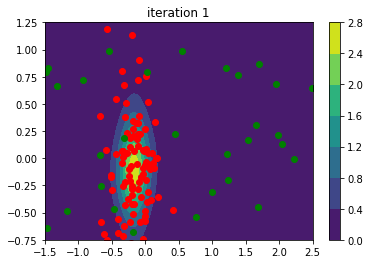

2000 2.50394606590271


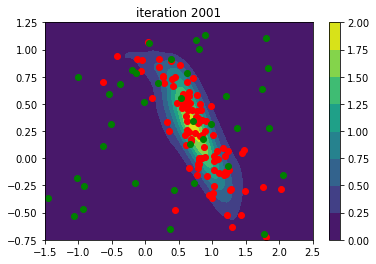

4000 1.963270664215088


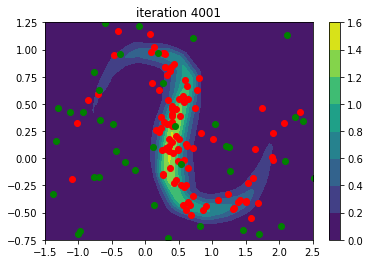

6000 1.6469097137451172


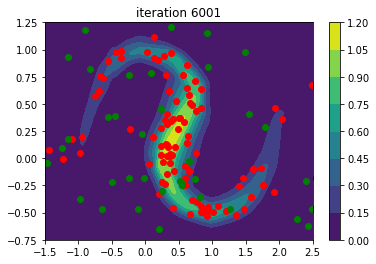

8000 1.3983309268951416


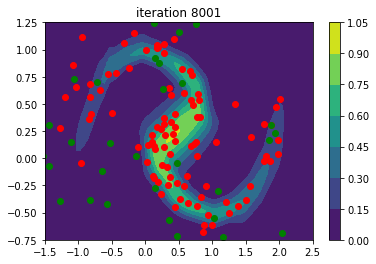

10000 1.4598057270050049


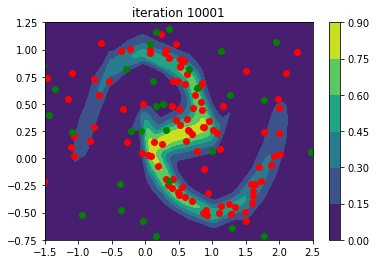

12000 1.1712031364440918


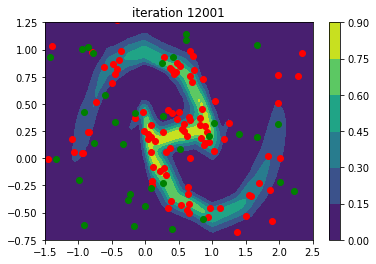

14000 1.3757836818695068


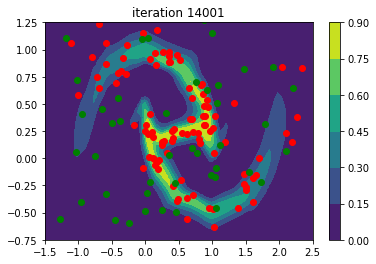

16000 1.3098223209381104


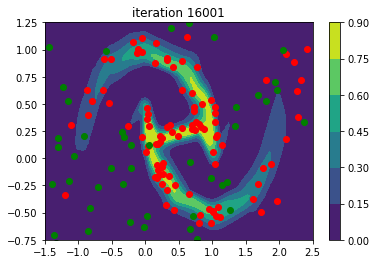

18000 1.3673982620239258


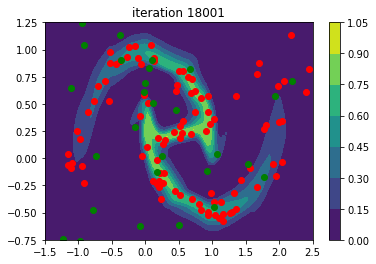

20000 1.3399665355682373


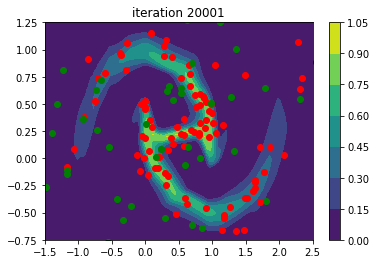

In [5]:
train_loss = train_moons(model, optimizer, n_epochs=20001, base_distr="logistic", plot_interval=2000)

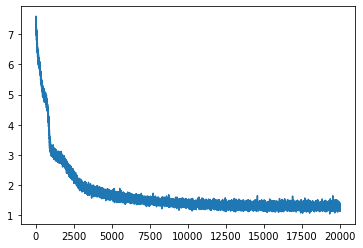

In [6]:
plt.plot(train_loss)
plt.show()

## References

<a id="reference1"></a>

[1] Dinh, L., Krueger, D., & Bengio, Y.Nice: Non-linear independent components estimation. arXiv preprint 	arXiv:1410.8516 . (2017). [link](https://arxiv.org/pdf/1410.8516.pdf)